In [201]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon,MultiPolygon,LineString,Point

In [202]:
AKL_df = pd.read_csv("./outputs/cleaned_property_data.csv",encoding='latin1')
AKL_df = AKL_df.drop(['Unnamed: 0'],axis=1)
print(AKL_df.head())
print(AKL_df.shape)

   CL_QPID  CL_Suburb  CL_Sale_Tenure  CL_Sale_Date  \
0    75738        256               0            46   
1    75814        223               0            38   
2    75835        223               0            17   
3    75842        223               0             8   
4    76103        181               0            40   

   CL_Land_Valuation_Capital_Value  CL_Building_Floor_Area  \
0                        -0.776857               -0.084574   
1                        -0.865695               -1.225402   
2                        -0.998952                2.538018   
3                        -1.206240               -1.225402   
4                        -0.836082                0.571074   

   CL_Building_Site_Cover  CL_Land_Area  CL_Bldg_Const  CL_Bldg_Cond  ...  \
0               -0.283212     14.915984              2             2  ...   
1               -1.177352      0.444313              3             0  ...   
2                1.147412      2.320124             13           

In [203]:
street_nodes_df = pd.read_csv("./outputs/akl_street_nodes.csv")
street_nodes_df = street_nodes_df[street_nodes_df.columns[:4]]
print(street_nodes_df.head())
print(street_nodes_df["street_id"].unique())

   street_id      source      target      street_name
0  984794487   279051892  2852049636  South Head Road
1  984794487  2852049636   279051893  South Head Road
2  984794487   279051903   279051892  South Head Road
3  984794487   279051893   279051895  South Head Road
4  984794487   279051895  7556143502  South Head Road
[ 984794487   25600792  808038023 ...  902227955  951612905 1020546217]


                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((222219.771 -4050395.343, 224043.539 ...  -35.698392  -37.364474   

    bbox_east   bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  175.903215  173.896328  298615087  relation  2094141 -36.541281  174.55061   

            display_name     class            type  importance  
0  Auckland, New Zealand  boundary  administrative        0.66  


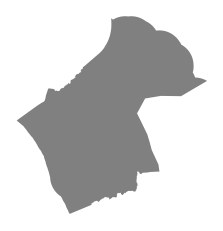

In [204]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [205]:
# Find Auckland BBox and download street informations
north, south, east, west = city_proj['bbox_north'][0],city_proj['bbox_south'][0],city_proj['bbox_east'][0],city_proj['bbox_west'][0]

highway_G = ox.graph_from_bbox(
    north,south,west,east,
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
projected_highway_G = ox.project_graph(highway_G)
print(projected_highway_G)

MultiDiGraph with 626825 nodes and 1284168 edges


In [206]:
longitude_list = AKL_df["CL_Longitude"].tolist()
latitude_list = AKL_df["CL_Latitude"].tolist()

points_list = [Point((lng, lat)) for lat, lng in zip(latitude_list, longitude_list)]

# then turn list into GeoSeries with original CRS set
# i'm just guessing that your original CRS is 4326
points = gpd.GeoSeries(points_list, crs='epsg:4326')

# then project your points to the same CRS as your projected graph
points_proj = points.to_crs(projected_highway_G.graph['crs'])
print(points_proj)

0        POINT (278912.809 -4014108.213)
1        POINT (254615.440 -4022788.934)
2        POINT (257896.471 -4026255.042)
3        POINT (257879.438 -4026294.869)
4        POINT (269113.381 -4017570.217)
                      ...               
82938    POINT (300739.957 -4081061.538)
82939    POINT (300739.957 -4081061.538)
82940    POINT (301409.993 -4087067.130)
82941    POINT (309700.230 -4084970.326)
82942    POINT (309700.060 -4084966.268)
Length: 82943, dtype: geometry


In [207]:
geo_x_list = []
geo_y_list = []
for coord in points_proj:
    if type(coord) == Polygon or type(coord) == MultiPolygon or type(coord) == LineString:
        coord = coord.centroid.xy
        x,y= coord[0][0],coord[1][0]
    else:
        x,y =  coord.x,coord.y
    #print(x,y)
    geo_x_list.append(x)
    geo_y_list.append(y)

In [208]:
def get_nearest_streets(x_list,y_list,road_G):
    return ox.distance.nearest_edges(road_G, x_list,y_list,return_dist=False)

In [209]:
nearest_edges = get_nearest_streets(geo_x_list,geo_y_list,projected_highway_G)

In [210]:
print(nearest_edges)

[(1874183568, 1874183557, 0), (2460839797, 7809299245, 0), (1256448996, 1256448947, 0), (9959069731, 1256448996, 0), (3924765687, 3924765686, 0), (1779093263, 1779093261, 0), (1779093213, 1779093216, 0), (1835700461, 2973853374, 0), (1041994125, 5190701506, 0), (6067809839, 7676095613, 0), (1041994035, 1041994227, 0), (7676095613, 1041994125, 0), (7676095613, 1041994125, 0), (1041994259, 7676129307, 0), (1249320119, 3553570478, 0), (1041994125, 1041994229, 0), (1511379588, 8049056171, 0), (1511379588, 8929718838, 0), (1511379588, 8929718838, 0), (1774285396, 719848, 0), (8049056172, 719844, 0), (1774285396, 719848, 0), (2969677579, 1015192332, 0), (2969677579, 2969677581, 0), (2969677579, 2969677581, 0), (8049056165, 8049056168, 0), (1015192295, 1015192332, 0), (1015192174, 1015192178, 0), (1015192248, 1015192278, 0), (1015192248, 1015192168, 0), (1015192178, 1015192174, 0), (1015192164, 1015192168, 0), (1015192248, 1015192278, 0), (1041983513, 4809475848, 0), (1041983495, 1041983464, 

In [211]:
def find_street_for_property(property_df,street_node_df):
    street_id_columns = []
    street_source_columns = []
    street_target_columns=[]
    street_with_no_match = 0
    for i in range(len(property_df)):
        u,v = nearest_edges[i][0],nearest_edges[i][1]
        #print("u={u},v={v}".format(u=u,v=v))
        street_node = street_node_df[street_node_df["source"] == u]
        street_node = street_node[street_node["target"] == v]
        if len(street_node) == 0:
            #print("Null, Reverse it!")
            street_node = street_node_df[street_node_df["source"] == v]
            street_node = street_node[street_node["target"] == u]
            if len(street_node) == 0:
                street_with_no_match += 1
        #print(street_node)
        street_id = street_node["street_id"].values
        #print("street_id={street_id}".format(street_id=street_id))
        street_id_columns.append(street_id)
        street_source_columns.append(u)
        street_target_columns.append(v)
        #break
    print("Street No Match = {street_with_no_match}".format(street_with_no_match=street_with_no_match))
    return street_id_columns,street_source_columns,street_target_columns

In [212]:
street_ids,street_sources,street_targets = find_street_for_property(AKL_df,street_nodes_df)
#print(street_ids,street_sources,street_targets)
AKL_df["street_id"] = street_ids
AKL_df["street_sources"] = street_sources
AKL_df["street_targets"] = street_targets
print(AKL_df.head())

Street No Match = 1310
   CL_QPID  CL_Suburb  CL_Sale_Tenure  CL_Sale_Date  \
0    75738        256               0            46   
1    75814        223               0            38   
2    75835        223               0            17   
3    75842        223               0             8   
4    76103        181               0            40   

   CL_Land_Valuation_Capital_Value  CL_Building_Floor_Area  \
0                        -0.776857               -0.084574   
1                        -0.865695               -1.225402   
2                        -0.998952                2.538018   
3                        -1.206240               -1.225402   
4                        -0.836082                0.571074   

   CL_Building_Site_Cover  CL_Land_Area  CL_Bldg_Const  CL_Bldg_Cond  ...  \
0               -0.283212     14.915984              2             2  ...   
1               -1.177352      0.444313              3             0  ...   
2                1.147412      2.320124   

In [213]:
print(AKL_df.shape)
AKL_df = AKL_df[AKL_df['street_id'].astype(bool)]
print(AKL_df.shape)

(82943, 25)
(81633, 25)


In [214]:
AKL_df = AKL_df.drop(["CL_Longitude","CL_Latitude"],axis=1)

In [215]:
AKL_df.to_csv("./outputs/property_data_with_street.csv")